In [89]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [90]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp


### Step 1: Read the Video/Image Data

Using PIMS, trackpy can read:

- a directory or zipfile of sequential images
- a multi-frame TIFF file
- a video (AVI, MOV, etc.)
- specialty formats used in microscopy and scientific video capture:
- Cine, NorPix seq
- LSM
- Files supported by Bioformats
- ND2 using PIMS_ND2

(Some of the formats require some extra dependencies. For a complete list, see the README page for PIMS, or the installation instructions in the documentation.)

For many formats, using pims.open just works. Since these images are in color, we also need to set up a pipeline to convert each image to grayscale when it is read

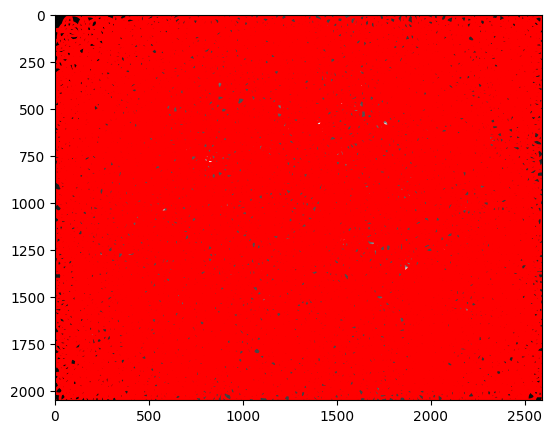

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,9.897030,212.710891,255.648743,6.951458,0.208417,2.024941,5801.0,-0.060251,0
1,9.656168,720.545932,192.875586,6.484992,0.202904,2.024941,15196.0,-0.104688,0
2,8.875706,1139.861582,179.207238,6.835641,0.083376,3.037411,22219.0,-0.233325,0
3,9.106095,1007.451467,224.262165,6.671763,0.253435,3.037411,20690.0,-0.184080,0
4,7.683473,2493.235294,180.725943,6.217126,0.185424,2.024941,8656.0,-0.069174,0
...,...,...,...,...,...,...,...,...,...
3515,2038.981132,1479.849057,160.982773,6.398211,0.204181,2.531176,23593.0,-0.307168,0
3516,2037.175166,1517.638581,228.312046,6.415060,0.104539,2.531176,23794.0,-0.322079,0
3517,2035.883721,1624.479070,217.681108,5.993019,0.082795,2.024941,23526.0,-0.302499,0
3518,2035.831239,1855.531418,281.972970,6.461459,0.041656,2.024941,22619.0,-0.250883,0


In [91]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel


frames = gray(pims.PyAVVideoReader(r'C:\Users\nohor3086\Desktop\Optical Tweezers Automation Project\Tracking_Backend\Sample_Recording\recording_2025-06-19_10-16-43.avi'))


# Find image features
f = tp.locate(frames[0], 21, invert=False)

tp.annotate(f, frames[0]);
f

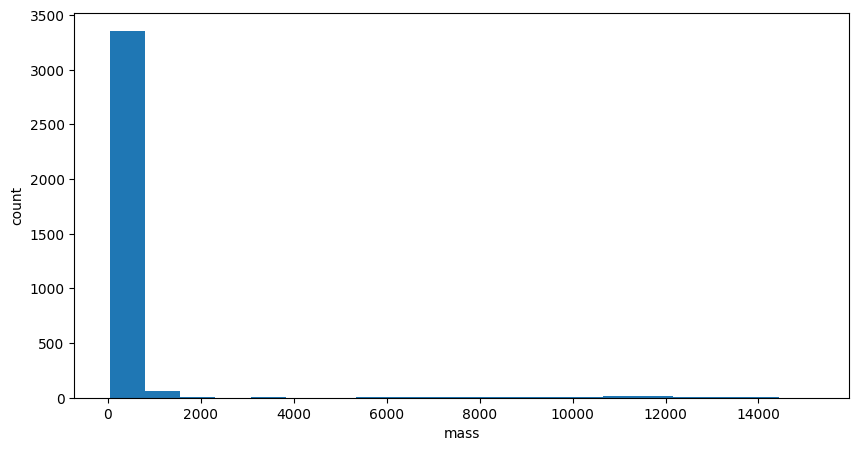

In [92]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

### Step 2: Cleaning up the Data

Now we see that a grand portion of these particles have a very small average brightness (mass) so we threshold them out.


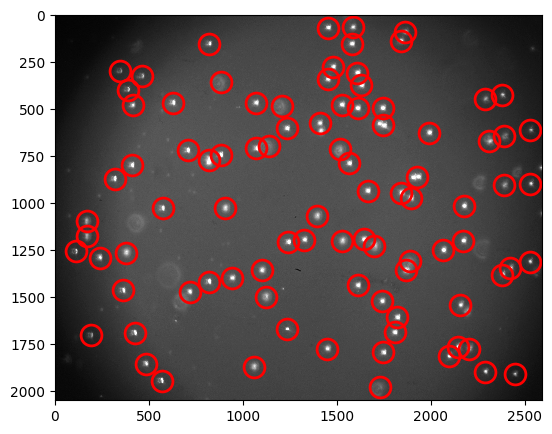

C:\Users\nohor3086\AppData\Roaming\Python\Python312\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


41


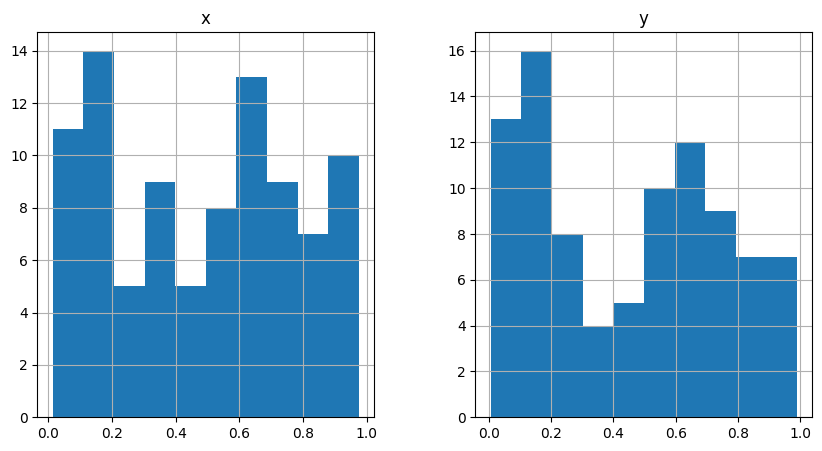

In [93]:

f_thresholded = tp.locate(frames[0], diameter=45, invert=False, minmass=9000)
tp.annotate(f_thresholded, frames[0])

# Check subpixel bias
tp.subpx_bias(f_thresholded)
print(len(frames))


# Step 3: Locate features in all frames
We do this by using a new function, the batch function trackpy.batch()

In [94]:
# to speed up the calculations we can turn off the verbose nature of the function to remove prints
frames = list(frames)  # load all frames into RAM
f_batch = tp.batch(frames, 45, minmass=9000, invert = False)

Frame 40: 91 features


# Step 4: Link the gathered trajectories 

We have the locations of the particles in each frame. Next we'll track particles from frame to frame, giving each one a number for identification.

First, we must must specify a maximum displacement, the farthest a particle can travel between frames. We should choose the smallest reasonable value because a large value slows computation time considerably. In this case, 5 pixels is reasonable.

Second, we allow for the possibility that a particle might be missed for a few frames and then seen again. (Perhaps its "mass" slipped below our cutoff due to noise in the video.) Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance. Here we use 3 frames.

In [95]:
trajectories  = tp.link(f_batch, 20, memory=20)
trajectories.head()

Frame 40: 91 trajectories present.


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,63.632631,1584.013566,37047.108737,8.335411,0.078980,136.890175,197058.0,0.064020,0,0
1,65.815399,1453.331714,47504.104249,8.755024,0.057688,129.178053,217310.0,0.050234,0,1
2,89.829854,1863.945539,34788.099505,8.150107,0.078371,138.175529,174517.0,0.092173,0,2
3,136.990166,1839.132922,40976.435180,8.124036,0.092370,138.175529,198343.0,0.062924,0,3
53,1192.032018,1643.323671,49639.719520,9.360705,0.015152,109.255070,249327.0,0.037477,0,4


# Step 5: Filter out stub/ephemeral trajectories

We filter out stub trajectories through the use of the trackpy.filter_stubs() functionality, where we pass in a minimum length required for all kept trajectories. In this case, we use 25 frames.

In [96]:
t1 = tp.filter_stubs(trajectories, 5)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', trajectories['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 105
After: 99


# Step 6: Further filtering through feature detection

We can also filter trajectories by their particles' appearance. At this stage, with trajectories linked, we can look at a feature's "average appearance" (average feature values throughout its entire trajectory) throughout its trajectory, giving a more accurate picture.

For example, one can take the mean of the particle size througought (radius) and mass througout (average brightness throughout whole trajectory).

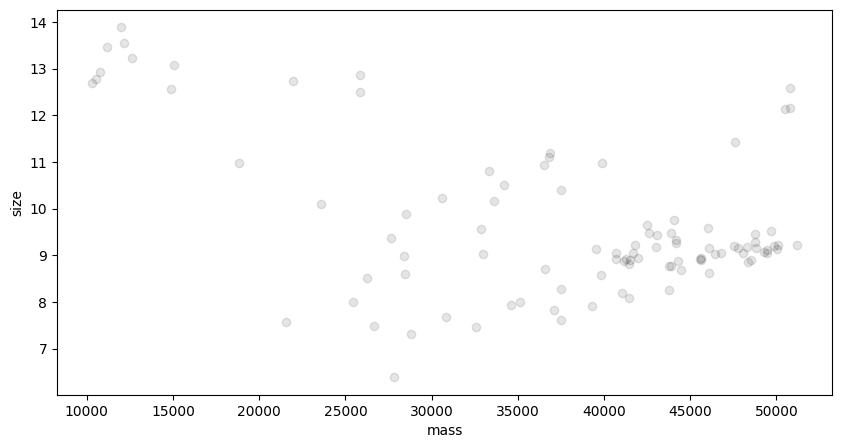

In [97]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

From these kinds of diagrams we can figure out which features are likely undesirable, and if there is a large variation in what we wish to detect. If there is something that we would like to remove, then we can simply filter it out using pandas dataframe modification.

In [98]:
# t2 = t1[((t1['mass'] > 50) & (t1['size'] < 2.6) &
#          (t1['ecc'] < 0.3))] # Here we perform conditional indexing to filter out only those with our desired feature values

# plt.figure()
# tp.mass_size(t2.groupby('particle').mean())

# print('Total Particles:', t2['particle'].nunique())


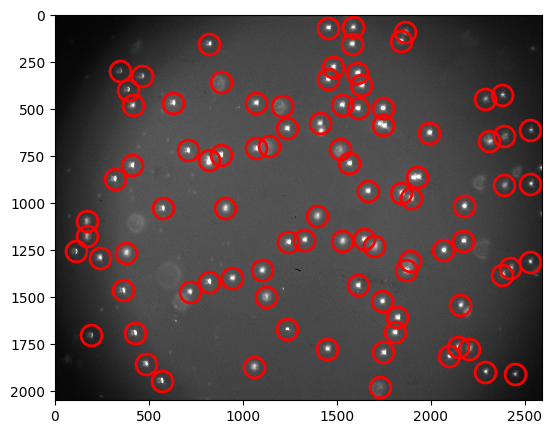

In [99]:
plt.figure()
tp.annotate(t1[t1['frame'] == 0], frames[0]);

# Step 7: Visualize particle trajectories

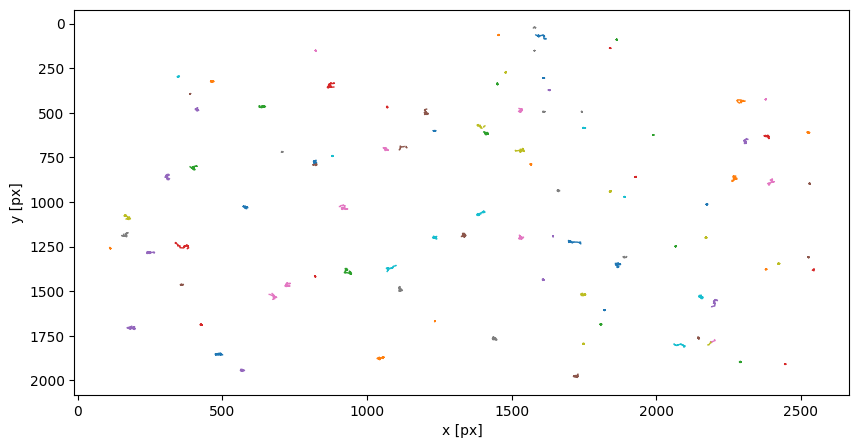

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [100]:
# To do so, it is as simple as:
plt.figure()
tp.plot_traj(t1)

## Step 8: Remove any flows/drifts present outside of Brownian Motion

In [101]:
d = tp.compute_drift(t1)
d

,y,x
frame,,
1,0.114999,0.924496
2,0.125462,0.694664
3,-0.130118,-0.191053
4,-0.226991,0.653621
5,-0.045587,0.635328
6,-0.176305,0.521364
7,-0.252018,0.732286
8,-0.336564,0.417868
9,-0.314478,0.346350


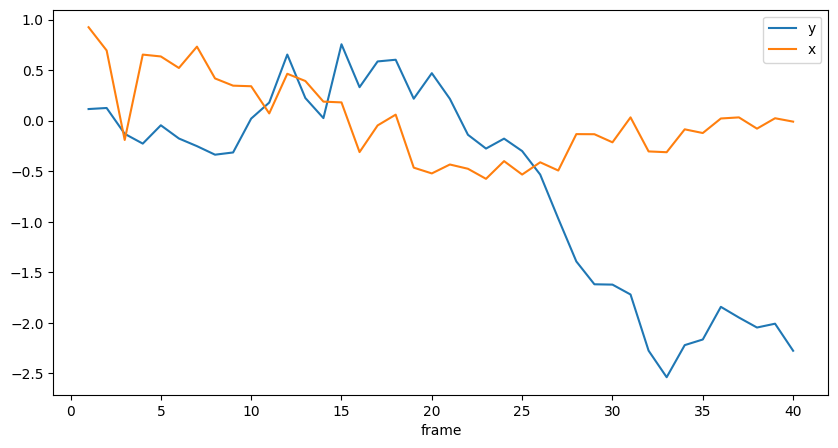

In [102]:
d.plot()
plt.show()

Some pretty significant linear pixel drift to be taken out.

In [103]:
tm = tp.subtract_drift(t1.copy(), d)

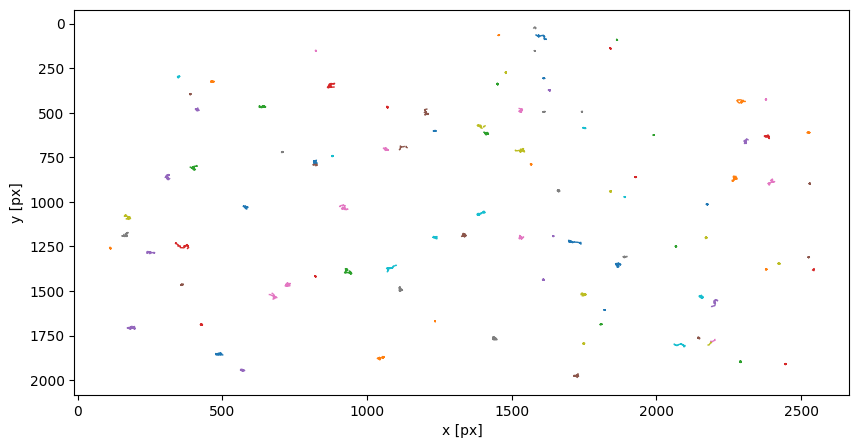

In [104]:
ax = tp.plot_traj(tm)
plt.show()

## Step 9: Analyze measured Brownian Motion

['frame', 'particle']
Index(['y', 'x', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep', 'frame',
       'particle'],
      dtype='object')
[None]
Index(['y', 'x', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep', 'frame',
       'particle'],
      dtype='object')


0         0
1         1
2         2
3         3
4         4
       ... 
3746     90
3747     93
3748     95
3749     96
3750    101
Name: particle, Length: 3751, dtype: int64

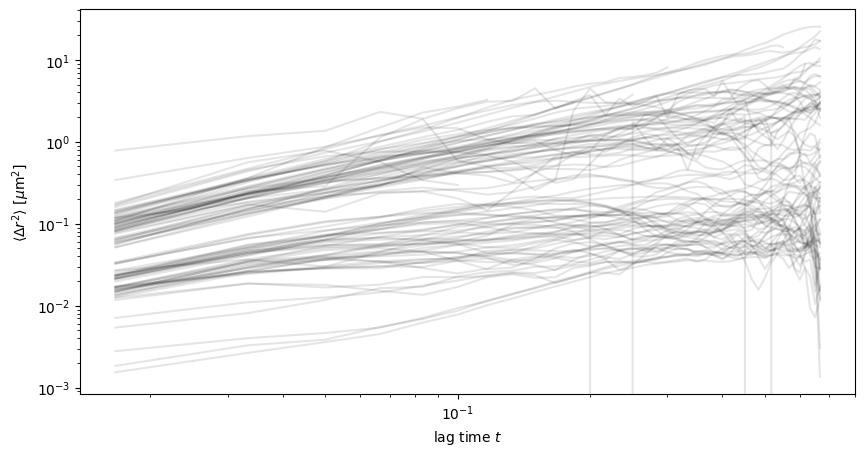

In [105]:
# This computes the mean squared displacement for each particle.
print(tm.index.names)
print(tm.columns)
tm = tm.reset_index(drop=True)
print(tm.index.names)
print(tm.columns)
display(tm['particle'])
# INDIVIDUAL PARTICLE IMSD CALCULATION
# im = tp.imsd(tm.loc[tm['particle']==8], 100/285., 24)  # microns per pixel = 100/285., frames per second = 24
im = tp.imsd(tm, 0.1, 60)

fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

[Text(0, 0.5, '$\\langle \\Delta r^2 \\rangle$ [$\\mu$m$^2$]'),
 Text(0.5, 0, 'lag time $t$')]

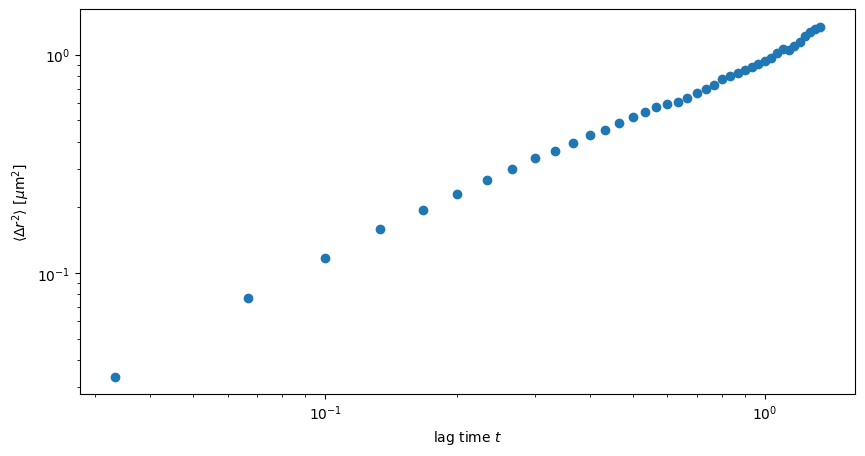

In [106]:
em = tp.emsd(tm, 0.0728, 30, max_lagtime=100) # microns per pixel, frames per second
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')


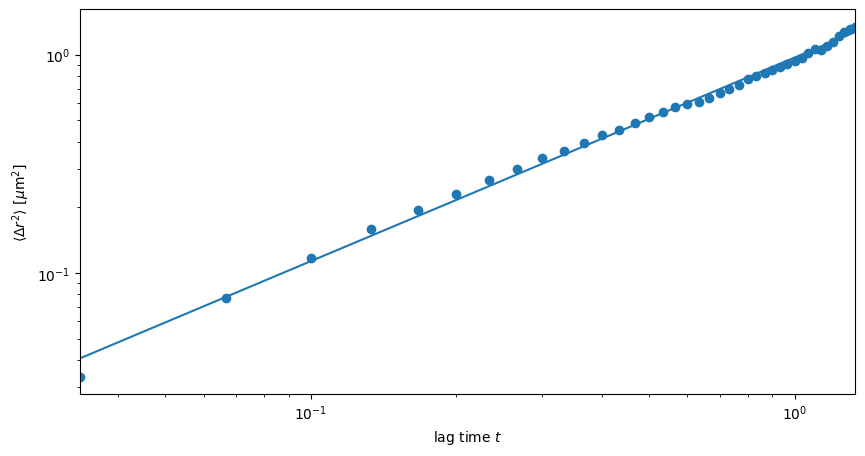

,n,A
msd,0.933034,0.970501


In [107]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em, plot=True)  # performs linear best fit in log space, plots]


In [108]:
A = float(tp.utils.fit_powerlaw(em, plot=False).A.iloc[0])
n = float(tp.utils.fit_powerlaw(em, plot=False).n.iloc[0])

D = (A/4)*10**(-12)
kb = 1.380649E-23
ROOM_TEMP_C = 22
T = ROOM_TEMP_C+273.15
eta = 1.002E-3

r = (kb*T)/(6*np.pi*eta*D)

print("Calculated Diffusion Coefficient: ", D*10**12, "um^2 s")
print("Calculated Particle Radius:",r*10**6,"um")
print("Calculated Particle Diameter:",2*r*10**6,"um")


Calculated Diffusion Coefficient:  0.24262518161402555 um^2 s
Calculated Particle Radius: 0.8892448366203405 um
Calculated Particle Diameter: 1.778489673240681 um
